# 1. Latent Factor Collaborative Filtering<br>
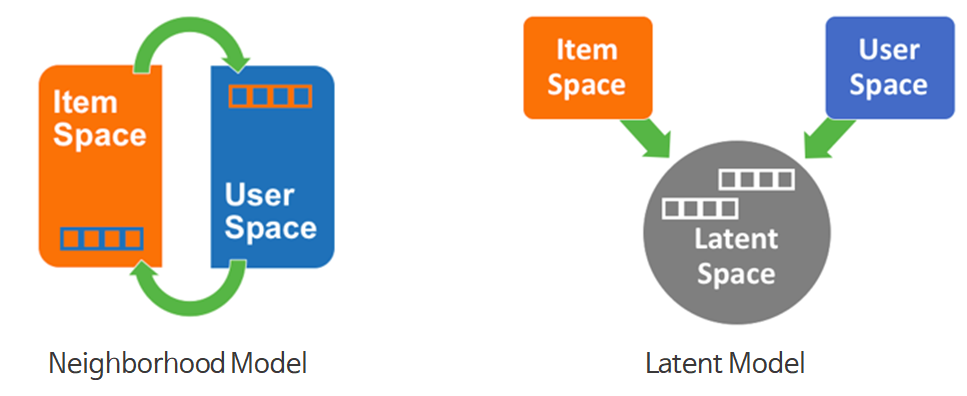<br>
- 정의<br>
**잠재 요인 협업 필터링**은 Rating Matrix에서 빈 공간을 채우기 위해서 사용자와 상품을 잘 표현하는 차원(Latent Factor)을 찾는 방법이다. 잘 알려진 행렬 분해는 추천 시스템에서 사용되는 협업 필터링 알고리즘의 한 종류이다. 행렬 분해 알고리즘은 사용자-아이템 상호 작용 행렬을 두 개의 저 차원 직사각형 행렬의 곱으로 분해하여 작동한다. 이 방법은 Netflix 챌린지에서 널리 알려지게 되었다.

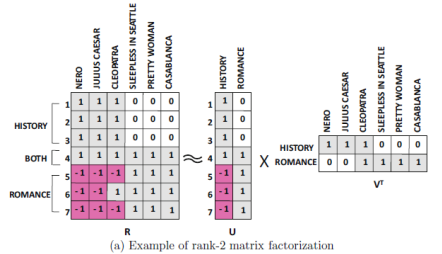

- 원리<br>
사용자의 잠재요인과 아이템의 잠재요인을 내적해서 평점 매트릭스를 계산하는 방식을 사용한다. 즉, 사용자의 잠재요인과 아이템의 잠재요인의 내적이 기존의 평점 매트릭스와 유사해지도록 만드는 잠재요인 값을 찾아야 한다. 하지만, 이런 잠재 요인 협업 필터링의 방법은 여러 가지가 있다. 대표적으로 넷플릭스 대회에서 사용한 SVD를 시작으로 최근 많이 사용하는 SGD, ALS가 있다.<br>
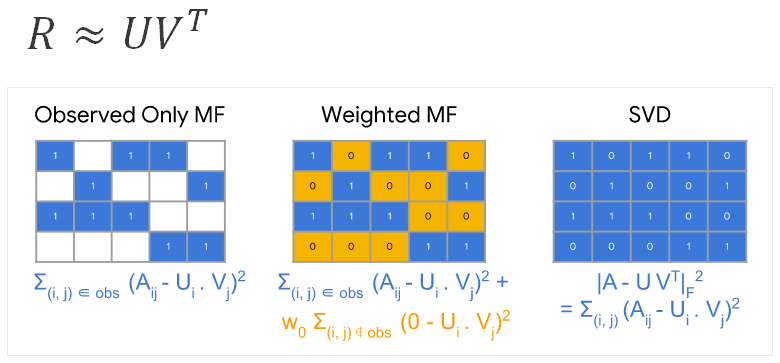

---

## 1. SVD
- 정의<br>
고유값 분해(eigen value Decomposition)와 같은 행렬을 대각화하는 방법
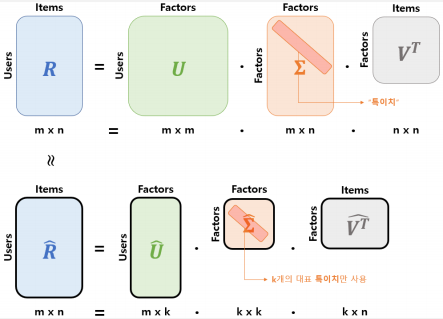

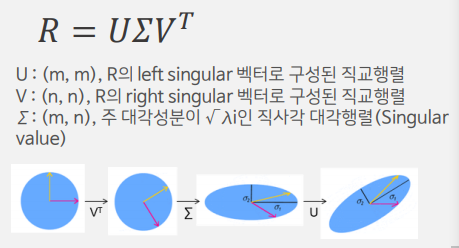

- 한계
    1. 데이터에 결측치가 없어야 함
    2. 대부분의 현업 데이터는 Sparse한 데이터

---

**SGD를 이용한 협업 필터링은 결측치와 상관없이 진행하는 장점이 있다.**
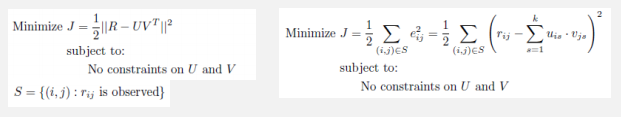<br>
기본적인 식은 위와 같다. 일단, 평점이 있는 부분에 대해서 Matrix Factorization을 시행하고 해당 부분의 오차를 최소화하는 것이다. 이 때, Gradient Descent처럼 오차를 최소화하는 방향을 찾기 위해 편미분이 수행된다.

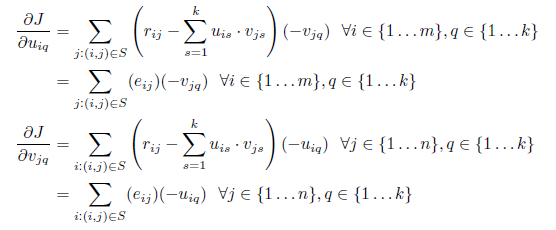

하지만, 딥러닝을 수행하다보면 보통 특정 Weight가 커지는 문제점이 생기고 이를 방지하기 위해서 Regularization을 수행한다. SGD에서도 마찬가지로 Regularization term을 두어서 Weight를 업데이트한다.

---

### 1.예시
Explict Feedback 된 형태의 4명의 유저에 대한 3개의 아이템에 대한 평점 Matrix<br>
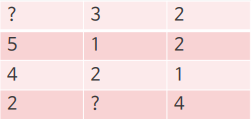

1. User Latent와 Item Latent의 임의로 초기화
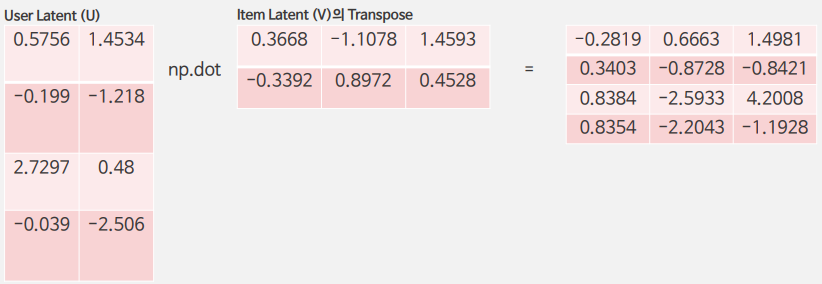<br>
먼저, 값이 존재하는 모든 평점에 대해서 순차적으로 Gradient Descent 과정을 진행한다. 아래는 평점 3인 부분에 대해서 오차를 계산하여 편미분을 계산한 것이다.

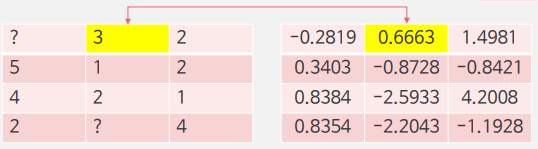

Error : $3 - -.6663 = 2.3337$<br> 
dUser = $-2.3337 * [-1/1078, 0.8972] + 0.01 * [0.5756. 1.4534]$  
Item = $-2.3337 * [0.5756. 1.4534] + 0.01 * [-1.1078, 0.8972]$

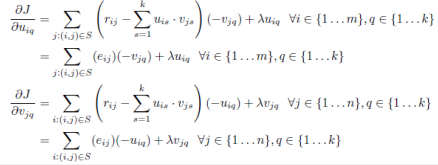

In [9]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm_notebook as tqdm

import numpy as np

# Base code : https://yamalab.tistory.com/92
class MatrixFactorization():
    def __init__(self, R, k, learning_rate, reg_param, epochs, verbose=False):
        """
        :param R: rating matrix
        :param k: latent parameter
        :param learning_rate: alpha on weight update
        :param reg_param: beta on weight update
        :param epochs: training epochs
        :param verbose: print status
        """

        self._R = R
        self._num_users, self._num_items = R.shape
        self._k = k
        self._learning_rate = learning_rate
        self._reg_param = reg_param
        self._epochs = epochs
        self._verbose = verbose


    def fit(self):
        """
        training Matrix Factorization : Update matrix latent weight and bias

        참고: self._b에 대한 설명
        - global bias: input R에서 평가가 매겨진 rating의 평균값을 global bias로 사용
        - 정규화 기능. 최종 rating에 음수가 들어가는 것 대신 latent feature에 음수가 포함되도록 해줌.

        :return: training_process
        """

        # init latent features
        self._P = np.random.normal(size=(self._num_users, self._k))
        self._Q = np.random.normal(size=(self._num_items, self._k))

        # init biases
        self._b_P = np.zeros(self._num_users)
        self._b_Q = np.zeros(self._num_items)
        self._b = np.mean(self._R[np.where(self._R != 0)])

        # train while epochs
        self._training_process = []
        for epoch in range(self._epochs):
            # rating이 존재하는 index를 기준으로 training
            xi, yi = self._R.nonzero()
            for i, j in zip(xi, yi):
                self.gradient_descent(i, j, self._R[i, j])
            cost = self.cost()
            self._training_process.append((epoch, cost))

            # print status
            if self._verbose == True and ((epoch + 1) % 10 == 0):
                print("Iteration: %d ; cost = %.4f" % (epoch + 1, cost))


    def cost(self):
        """
        compute root mean square error
        :return: rmse cost
        """

        # xi, yi: R[xi, yi]는 nonzero인 value를 의미한다.
        # 참고: http://codepractice.tistory.com/90
        xi, yi = self._R.nonzero()
        # predicted = self.get_complete_matrix()
        cost = 0
        for x, y in zip(xi, yi):
            cost += pow(self._R[x, y] - self.get_prediction(x, y), 2)
        return np.sqrt(cost/len(xi))


    def gradient(self, error, i, j):
        """
        gradient of latent feature for GD

        :param error: rating - prediction error
        :param i: user index
        :param j: item index
        :return: gradient of latent feature tuple
        """

        dp = (error * self._Q[j, :]) - (self._reg_param * self._P[i, :])
        dq = (error * self._P[i, :]) - (self._reg_param * self._Q[j, :])
        return dp, dq


    def gradient_descent(self, i, j, rating):
        """
        graident descent function

        :param i: user index of matrix
        :param j: item index of matrix
        :param rating: rating of (i,j)
        """

        # get error
        prediction = self.get_prediction(i, j)
        error = rating - prediction

        # update biases
        self._b_P[i] += self._learning_rate * (error - self._reg_param * self._b_P[i])
        self._b_Q[j] += self._learning_rate * (error - self._reg_param * self._b_Q[j])

        # update latent feature
        dp, dq = self.gradient(error, i, j)
        self._P[i, :] += self._learning_rate * dp
        self._Q[j, :] += self._learning_rate * dq


    def get_prediction(self, i, j):
        """
        get predicted rating: user_i, item_j
        :return: prediction of r_ij
        """
        return self._b + self._b_P[i] + self._b_Q[j] + self._P[i, :].dot(self._Q[j, :].T)


    def get_complete_matrix(self):
        """
        computer complete matrix PXQ + P.bias + Q.bias + global bias

        - PXQ 행렬에 b_P[:, np.newaxis]를 더하는 것은 각 열마다 bias를 더해주는 것
        - b_Q[np.newaxis:, ]를 더하는 것은 각 행마다 bias를 더해주는 것
        - b를 더하는 것은 각 element마다 bias를 더해주는 것

        - newaxis: 차원을 추가해줌. 1차원인 Latent들로 2차원의 R에 행/열 단위 연산을 해주기위해 차원을 추가하는 것.

        :return: complete matrix R^
        """
        return self._b + self._b_P[:, np.newaxis] + self._b_Q[np.newaxis:, ] + self._P.dot(self._Q.T)



# run example
if __name__ == "__main__":
    # rating matrix - User X Item : (7 X 5)
    R = np.array([
        [1, 0, 0, 1, 3],
        [2, 0, 3, 1, 1],
        [1, 2, 0, 5, 0],
        [1, 0, 0, 4, 4],
        [2, 1, 5, 4, 0],
        [5, 1, 5, 4, 0],
        [0, 0, 0, 1, 0],
    ])

    # P, Q is (7 X k), (k X 5) matrix

In [10]:
%%time
factorizer = MatrixFactorization(R, k=3, learning_rate=0.01, reg_param=0.01, epochs=100, verbose=True)
factorizer.fit()

Iteration: 10 ; cost = 1.2925
Iteration: 20 ; cost = 0.9489
Iteration: 30 ; cost = 0.7828
Iteration: 40 ; cost = 0.6711
Iteration: 50 ; cost = 0.5747
Iteration: 60 ; cost = 0.4871
Iteration: 70 ; cost = 0.4124
Iteration: 80 ; cost = 0.3541
Iteration: 90 ; cost = 0.3112
Iteration: 100 ; cost = 0.2800
Wall time: 74.8 ms


In [ ]:
factorizer.get_complete_matrix()